In [30]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
sys.path.append("../../lexrank/")
from lexrank.lexrank import  degree_centrality_scores
from modules import utils,modeling

from sentence_transformers import SentenceTransformer,util
import plotly.express as px
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score,make_scorer

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from sentence_transformers import models

from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from modules.NLPipe import NLPipe

from modules.modeling import scatter_plot,bar_plot

pd.set_option('display.max_colwidth', 1000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=250)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
# join BERT model and pooling to get the sentence transformer
embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

### Let's load the data and do some minimal prep.

- removing mediathek departmant as these are videos and podcast
- filtering out articles shorter than 100 characters

In [2]:
df = pd.read_csv("../data/welt_articles.csv", index_col=0)
df = df[df.department != "mediathek"]
df = df[df.text.str.len() > 250]

df = df.rename(columns={"date": "created_at"})
df = df.sort_values(by='created_at').tail(500)
df.created_at = pd.to_datetime(df.created_at, dayfirst=True)
df.created_at = df.created_at.apply(lambda x: x.date()).apply(str)
df = df.rename(columns={"title": "headline"})

"We have {} articles. ".format(df.shape[0],df.text.apply(lambda x: x.split(" ")))

'We have 500 articles. '

In [3]:
pdf = utils.preprocess_articles_for_bert(df,"text",lower=True)

for nr in  range(50,55):
    print(df.text.values[nr][:100]," \n -> ",pdf[nr][:150]+"...")
    print()

Wer vor der deutschen Küste Windräder aufstellen will, muss erst einmal Kampfmittelräumer beauftrage  
 ->  wer vor der deutschen küste windräder aufstellen will, muss erst einmal kampfmittelräumer beauftragen. sonst könnte es sein, dass ihm das ganze schnel...

Mit dem Teil-Lockdown kommt es in Hamburg auch wieder zu coronabedingten Hamsterkäufen. Nudeln, Kons  
 ->  mit dem teil-lockdown kommt es in hamburg auch wieder zu coronabedingten hamsterkäufen. nudeln, konserven und toilettenpapier seien derzeit kassenschl...

Bis zum Jahr 2040 werden in Nordrhein-Westfalen über eine Million neue Wohnungen gebraucht. Das geht  
 ->  bis zum jahr 2040 werden in nordrhein-westfalen über eine million neue wohnungen gebraucht. das geht aus einer am donnerstag in düsseldorf vorgestellt...

Vor einem Behördengebäude in Arizona, in dem Stimmen der US-Präsidentenwahl ausgezählt werden, hat s  
 ->  vor einem behördengebäude in arizona, in dem stimmen der us-präsidentenwahl ausgezählt werden, hat sich

In [4]:
df.head()

,headline,seo_title,department,text,created_at,importer
cms_id,,,,,,
219366892,„Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen“,Verfassungsschutzchef: „Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen“,newsteam,"Verfassungsschutzchef Thomas Haldenwang sieht nach mehreren islamistischen Terroranschlägen in den vergangenen Wochen eine Gefahr durch Nachahmer. Man müsse einen „sehr scharfen Blick auf die uns bekannten Gefährder werfen, denn es gibt sicherlich den oder die ein oder andere, die über Nachahmungstaten nachdenkt“, sagte der Präsident des Bundesamts für Verfassungsschutz dem ARD-Hauptstadtstudio. Die Sicherheitsbehörden in Deutschland müssten zurzeit „sehr wachsam“ sein.„Ich habe in den vergangenen Jahren immer gesagt, die Gefährdungssituation durch den islamistischen Terrorismus ist unverändert hoch – wir müssen jeden Tag auch in Deutschland mit einem islamistischen Anschlag rechnen“, sagte Haldenwang. Als Hauptauslöser für die islamistisch motivierten Anschläge in den vergangenen Wochen sieht der Verfassungsschutz demnach die neuerliche Diskussion um die Mohammed-Karikaturen in Frankreich. Das Thema habe „die Emotionen der Islamisten sehr stark hochkochen lassen“, sagte Haldenwang...",2020-11-05,welt
219336908,Welche Rolle spielte „Monitor“ beim Bad-Kleinen-Skandal?,Bad Kleinen 1993: Die Rolle von „Monitor“ beim Skandal,geschichte,"Der Skandal begann mit einer Vorabmeldung. Am Donnerstag, dem 1. Juli 1993, verbreitete das WDR-Magazin „Monitor“ über die Nachrichtenagenturen einen Verdacht: Beim Einsatz des Bundeskriminalamtes (BKA) und der Anti-Terror-Einheit GSG-9 am vorangegangenen Sonntag in Bad Kleinen sei der RAF-Terrorist Wolfgang Grams „am Tatort regelrecht hingerichtet“ worden. Das bestätige auch ein erster Obduktionsbefund. In seiner Abmoderation nach der Ausstrahlung des „Monitor“-Beitrages am selben Abend fügte Moderator Klaus Bednarz in düsterem Tonfall hinzu: „Alles deutet auf Exekution. Ein ungeheuerlicher Vorgang, der in der Geschichte der Bundesrepublik – zumindest soweit bekannt – nicht seinesgleichen hat.“ Heute ist längst bekannt, dass es sich bei dem „Verdacht“ um eine freie Erfindung gehandelt hat. Grams erschoss sich in gefühlt aussichtsloser Lage selbst. Genau das deutete auch der erste Obduktionsbefund vom 30. Juni 1993 an, auf den Bednarz hingewiesen hatte: Beim tödlichen Treffer hande...",2020-11-05,welt
219401376,Corona-Schnelltests zuerst für Altenheime,Corona-Schnelltests zunächst für Altenheime reserviert,regional,"Die Bewohner der Alten- und Pflegeheime in Nordrhein-Westfalen sollen als Erste mit den jetzt verfügbaren Corona-Schnelltests beliefert werden. Eine entsprechende Vereinbarung habe man mit den Apotheken abgeschlossen, sagte Gesundheitsminister Karl-Josef Laumann (CDU) am Mittwoch (4.11.). Es seien genug Kapazitäten auf dem Markt vorhanden, so solle aber eventuellen Engpässen vorgebeugt werden. Geplant sei, dass ein Alten- oder Pflegeheim im Monat pro Bewohner 20 Schnelltests bekomme. Das wären monatlich rund 3,4 Millionen Tests. Diese könnten für Personal, Bewohner und Besucher eingesetzt werden. Das könnten die Heime selber entscheiden.1000 Bewohner mit Corona infiziertDas Personal in den Heimen soll die Tests – nach Schulung durch Ärzte – selbst vornehmen. Das Land übernimmt die Kosten von bis zu 20 Tests im Monat pro Bewohner. Die Tests sollen laut der entsprechenden Allgemeinverfügung am 9. November starten.Derzeit gibt es Laumann zufolge rund 1000 infizierte Bewohner und eben...",2020-11-05,welt
219300710,Erdogan und die Helden von Wien,Terror in Wien: Recep Tayyip Erdogan und seine Helden,politik/ausland,"Niemand, außer vielleicht Angehörige von Spezialkräften oder ausgebildete Personenschützer, kann von sich mit Gewissheit sagen, wie er sich verhalten würde, wenn er sich plötzlich inmitten eines terroristischen Anschlags wiederfände. Ob er die richtigen Entscheidungen treffen würde, ob er gar sein eigenes Leben riskieren w

## Document embedding and clustering

In [5]:
#### For some extra performance let's join headline with text as it caries a lot of info.
df.text = df.headline + ". " + df.text
####
nlpipe = NLPipe(df)
nlpipe._store_headlines() 
nlpipe._store_created_at()
embedded = nlpipe.cleantext().embed(batch_size=50).normalize()

cluster_results = embedded.reduce_dim().cluster_hdbscan(cluster_selection_method="leaf")
viz_dimensions = embedded.reduce_dim( model_path="../models/bert-german-dbmdz-uncased-sentence-stsb/umap_viz_100_19-neighbors_0.01-min-dist.pkl").value()



--- UMAP Loaded in 7.69547176361084 seconds 
--- Reduced dimensionality to (500, 384) .
>> --- Done in 0.1 seconds ---
--- UMAP Loaded in 3.4039769172668457 seconds 
--- Reduced dimensionality to (500, 2) .


## Preprocesing clustring results for viz
Linking the encodings with creation date and headline for viz

In [6]:
res = pd.DataFrame(viz_dimensions,columns=['x', 'y'])

res['labels'] = cluster_results.value()
res['headline'] = nlpipe.data.headlines
res['created_at'] = nlpipe.data.created_at

# Summarizing the clusters

In [13]:

docs_df = pd.DataFrame(embedded.data.pdf, columns=["Doc"])
docs_df['Topic'] = cluster_results.value()
docs_df['Doc_ID'] = df.index.values
docs_per_topic = docs_df.groupby(['Topic'], as_index = True).agg({'Doc': ' '.join})# For every topic collect all the article and join their texts (preprocessed) , raw texts, 


docs_per_topic.head(2)

,Doc
Topic,
-1,"Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen. Verfassungsschutzchef Thomas Haldenwang sieht nach mehreren islamistischen Terroranschlägen in den vergangenen Wochen eine Gefahr durch Nachahmer. Man müsse einen sehr scharfen Blick auf die uns bekannten Gefährder werfen, denn es gibt sicherlich den oder die ein oder andere, die über Nachahmungstaten nachdenkt, sagte der Präsident des Bundesamts für Verfassungsschutz dem ARD-Hauptstadtstudio. Die Sicherheitsbehörden in Deutschland müssten zurzeit sehr wachsam sein.Ich habe in den vergangenen Jahren immer gesagt, die Gefährdungssituation durch den islamistischen Terrorismus ist unverändert hoch wir müssen jeden Tag auch in Deutschland mit einem islamistischen Anschlag rechnen, sagte Haldenwang. Als Hauptauslöser für die islamistisch motivierten Anschläge in den vergangenen Wochen sieht der Verfassungsschutz demnach die neuerliche Diskussion um die Mohammed-Karikaturen in Frankreich. Das Thema habe die Emotion..."
0,"Mein Kurzzeitgedächtnis ist hinüber. Schauspieler Michael J. Fox 59, Zurück in die Zukunft stand trotz seiner langjährigen Parkinson-Erkrankung gelegentlich noch vor der Kamera. Doch nun hat er im Interview mit der US-Zeitschrift People über einen weiteren Rückschlag gesprochen. Mein Kurzzeitgedächtnis ist hinüber, sagt Fox in dem am Mittwoch veröffentlichten Artikel. Er würde sich nun auf das Schreiben konzentrieren. Seine vierte Biografie No Time Like the Future soll Mitte November in den USA erscheinen.Er könne nicht mehr Gitarre spielen oder zeichnen, sagte Fox. Tanzen sei nie seine Stärke gewesen und schauspielern sei nun schwierig. Mir bleibt das Schreiben und glücklicherweise macht mir das wirklich Spaß. Der Kanadier leidet seit 1991 an der Schüttellähmung. Wegen der Krankheit beendete er im Jahr 2000 seine Kinokarriere, spielte jedoch weiterhin in TV-Serien wie Spin City und bis 2016 in The Good Wife mit.Fox sprach über weitere Tiefschläge im Jahr 2018, die ihm schwer zuges..."


In [15]:
def lexrank_summarize(cluster_doc):
    sentences = nltk.sent_tokenize(cluster_doc)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = embedder.encode(sentences, convert_to_tensor=True)

    #Compute the pair-wise cosine similarities
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy()

    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    return " ".join([sentences[idx].strip() for idx in most_central_sentence_indices[0:1]])
    

## Cluster-based TF-IDF + Cluster Summary

In [16]:
tf_idf, count = utils.c_tf_idf(docs_per_topic.Doc.values, m=len(embedded.data.pdf),ngram_range=(1,2),remove_stop_words=True)
top_n_words = utils.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic.reset_index(), n=20)
top_6_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:7]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])
top_6_words_per_topic["Topic"]=top_6_words_per_topic["Topic"].apply(int)
topic_sizes = utils.extract_topic_sizes(docs_df)
top_6_words_per_topic["Summary"] = top_6_words_per_topic.Topic.apply(lambda x: lexrank_summarize(docs_per_topic.loc[x].Doc) )
top_6_words_per_topic=top_6_words_per_topic.set_index("Topic")


top_6_words_per_topic

Number of stopwords 607


,top_n_words,Summary
Topic,,
-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
0,las vegas | vegas | las | jenkins | brady | bundesstaat | clark county,"Die Anzahl der in Wilmington abgestellten Mitarbeiter entspricht demnach aber nicht dem Schutz, der einem designierten Präsidenten zusteht.Auszählung läuft weiterDer Demokrat hat nach dem Gewinn wichtiger Bundestaaten gute Aussichten auf einen Erfolg bei der US-Präsidentenwahl."
1,playstation | sony | ipad | ki | wordpress | konsole | apple,"Alternativ dazu empfiehlt das BSI auch das Programm Parted Magic, das sich zugleich zum Wiederherstellen von Daten verwenden lässt.Smartphones sind meist verschlüsseltBei Smartphones sei die Bereinigung dagegen besonders einfach, sagt Patrick Bellmer."
2,verschlüsselung | nehammer | övp | wien | generalschlüssel | österreich | muslimbruderschaft,"Innerhalb der Behörden werde ermittelt, wie Details über eine geheime Operation an die Öffentlichkeit gelangen konnten, sagte der Chef der obersten Polizeibehörde, Franz Ruf.Die österreichische Regierung hatte nach dem Terroranschlag von Wien mit vier Todesopfern und über 20 Verletzten angekündigt, verstärkt gegen die Ideologie des politischen Islams vorzugehen."
3,leclerc | ferrari | formel | bei ferrari | der formel | schumacher | vettel,"Das hat mir in der Qualifikation geholfen und auch dabei, ein bisschen konstanter am Limit des Autos zu fahren.Frage Und Vettel?Leclerc Ich glaube, es ist auch für Seb ein schwieriges Jahr, auch weil es seine letzte Saison bei Ferrari ist."
4,havener | körpersprache | gesten | hopp | zeichen | clemens | aumio,"Der Experte empfiehlt, zusätzlich auf andere Details zu achten Wenn der andere beispielsweise nickt, während man selbst das auch tut, dann sei das ein Zeichen echten Interesses.Grundsätzlich gelte es, auf offene und geschlossene Gesten zu achten offene Handflächen, zugewandte Fußspitzen oder die Annäherung des Oberkörpers sind gute Zeichen."
5,heinisch | na na | na | ufc | amerika | sagt heinisch | ian heinisch,"Rasch kursiert ein Videoclip, der zeigt, wie Harris mit Biden telefoniert, ihm lachend zuruft Wir habens geschafft, wir habens geschafft, Joe.Die spontane Feier am Weißen Haus aber ist nicht nur eine Feier von Bidens Sieg, es ist auch eine Feier über die Niederlage des abgewählten, noch amtierenden Präsidenten Donald Trump."
6,santo | bulgaren | lächeln | der kapverden | antão | santo antão | kapverden,"Er erwartet uns schon.Vom Vulkan geht es in die grünen BergeMit unserer Küstentour haben wir nur eine Facette der Insel als Outdoorziel kennengelernt, eine faszinierende zwar, aber Santo Antão bietet mehr."
7,boldt | hsv | würzburg | antwerpen | der hsv | magath | schiele,"Und er ändert so viel, dass der HSV-Aufsichtsratsvorsitzende Marcell Jansen in der vergangenen Woche bündig feststellte Wir haben großes Vertrauen in Jonas’ Arbeit und wollen die sportlich strategische Gesamtentwicklung fortsetzen.Also wurde der Vertrag mit dem neuen Architekten des Vereins bis Juni 2023 verlängert, punktgenau vor dem schweren Auswärtsspiel bei Holstein Kiel am Montagabend."


Outliers (-1, 149)


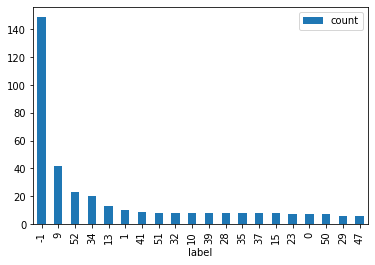

In [22]:
ctr=Counter(res.labels).most_common(20)
print("Outliers {}".format(ctr[0]))
pd.DataFrame(ctr,columns=['label','count']).set_index("label").plot(kind='bar')

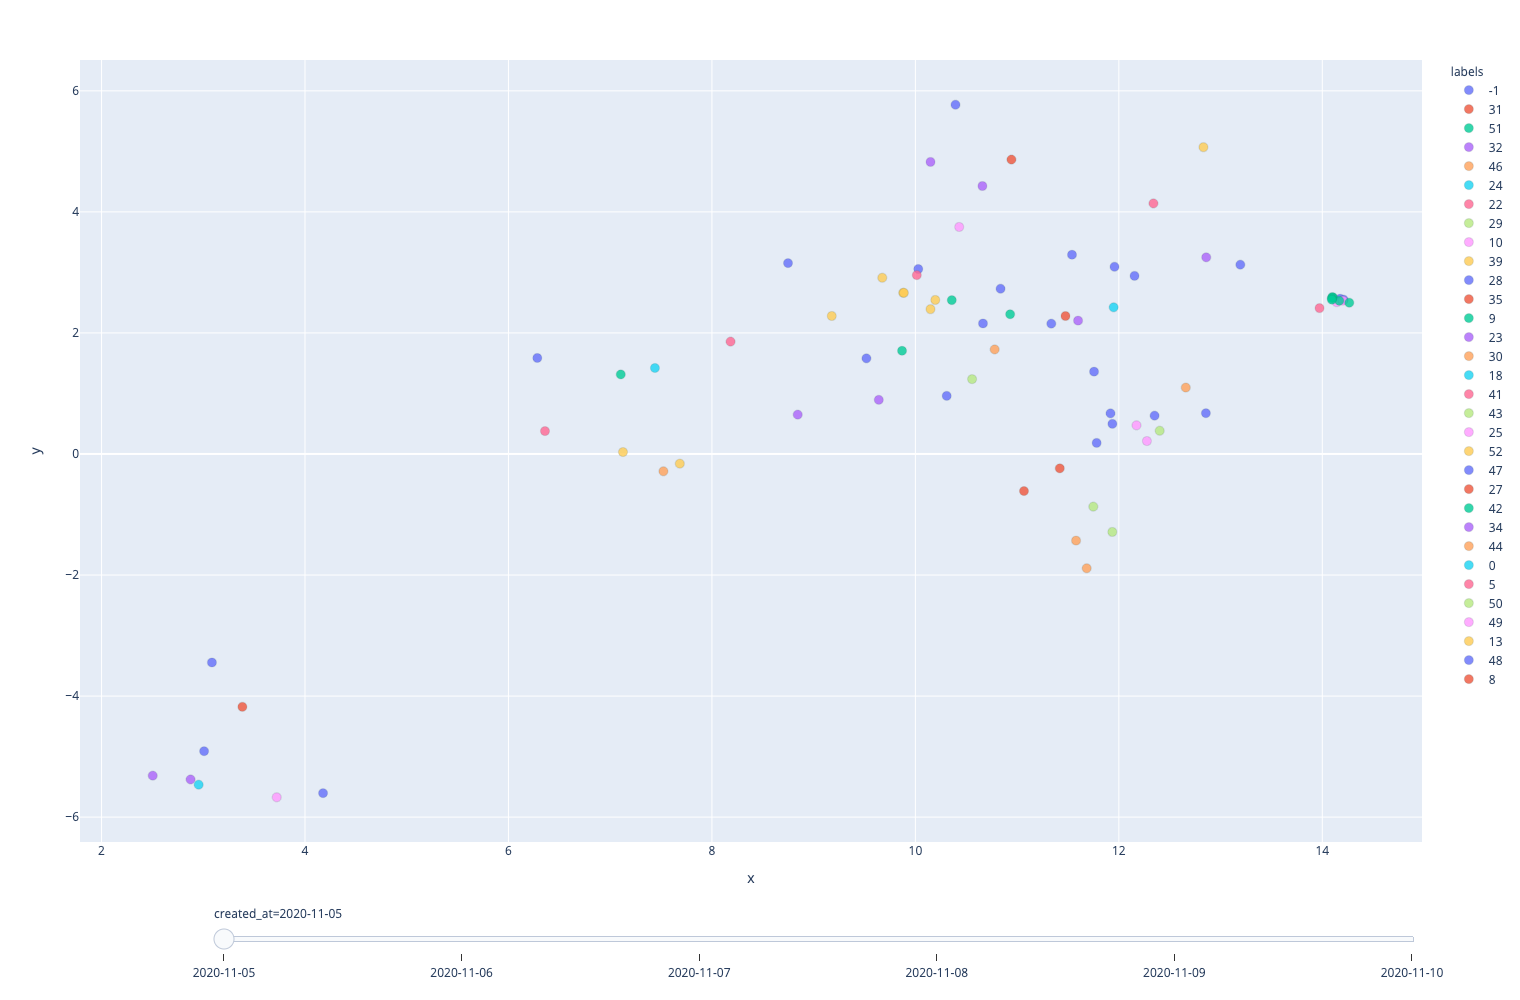

In [37]:
res.labels=res.labels.apply(str)
top_6_words_per_topic.index = top_6_words_per_topic.reset_index().Topic.apply(str)
_res = pd.merge(res,top_6_words_per_topic.reset_index(),left_on="labels",right_on="Topic")

import textwrap

_res["Summary"]=_res["Summary"].apply(
    lambda t: "<br>".join(textwrap.wrap(t))
)
scatter_plot(_res,animation_frame="created_at",hover_data=["created_at","Summary","top_n_words"])

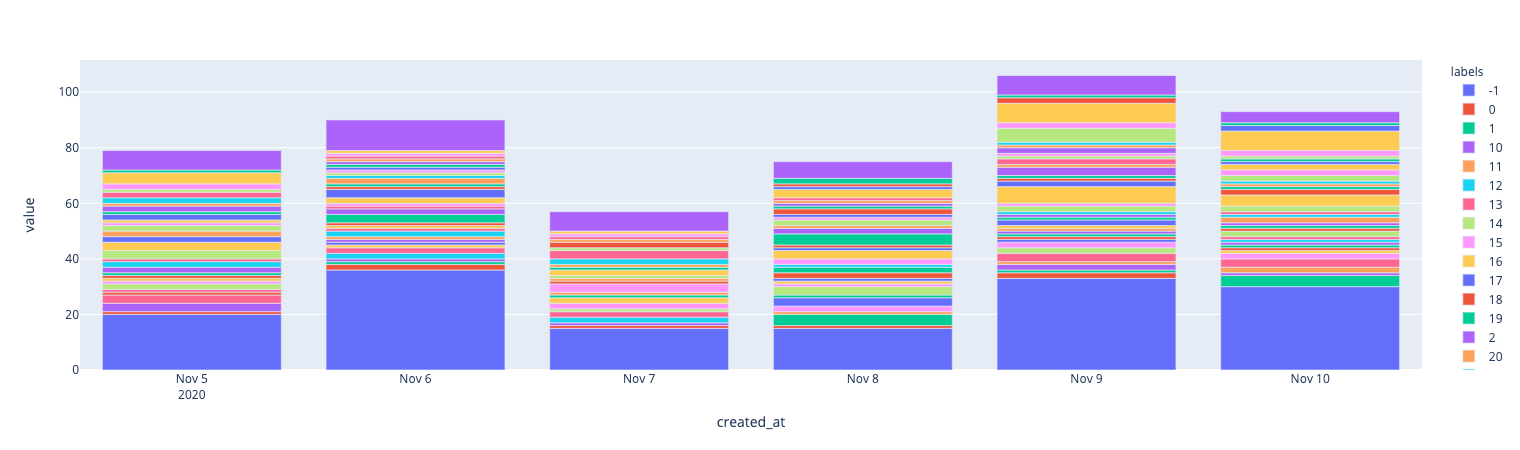

In [38]:
bar_plot(_res)

In [ ]:
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=250)

# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
#                                pooling_mode_mean_tokens=True,
#                                pooling_mode_cls_token=False,
#                                pooling_mode_max_tokens=False)

# # join BERT model and pooling to get the sentence transformer
# embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# # Corpus with example sentences
# corpus = pdf
# corpus_embeddings = embedder.encode(corpus)

# # Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# # Perform kmean clustering
# clustering_model = AgglomerativeClustering(n_clusters=None ,affinity='cosine', linkage='average', distance_threshold=0.4)
# clustering_model.fit(corpus_embeddings)
# cluster_assignment = clustering_model.labels_


In [29]:
_res

,x,y,labels,headline,created_at,Topic,top_n_words,Summary
0,11.957416,3.093269,-1,„Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen“,2020-11-05,-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
1,3.008261,-4.910741,-1,„Irgendwann kommst du an die Grenze. Das sieht man am Beispiel Alaba“,2020-11-05,-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
2,6.283617,1.586681,-1,Tod aus dem Märchenwald,2020-11-05,-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
3,13.194310,3.127985,-1,Das Gebot zu töten ist ein wichtiger Bestandteil der islamischen Quellen,2020-11-05,-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
4,14.175340,2.565392,-1,Warum der 8. Dezember nun ein ganz zentraler Tag im Wahlkrimi ist,2020-11-05,-1,to | of | that | and | the | buck | is,"Für die Zeit des von der Bundesregierung verordneten Lockdown light versprach Scholz in dieser Größenordnung bisher unbekannte Unterstützungsleistungen, um in die Krise geratenen Unternehmen zu helfen, und deutete damit präventiv schon einmal an, dass die Kassen bald leer sein könnten.Der bayerische Ministerpräsident Markus Söder fand für die Liebe zum Staat, die er den Bürgern für die Zeit des gesundheitspolitischen Überlebenskampfes anempfahl, die noch zackigere Maxime Wir sind eine Solidargemeinschaft und kein Ego-Land."
...,...,...,...,...,...,...,...,...
495,10.195055,-0.564215,6,Die Pfeifsprache auf La Gomera kennt 4000 Wörter,2020-11-10,6,santo | bulgaren | lächeln | der kapverden | antão | santo antão | kapverden,"Er erwartet uns schon.Vom Vulkan geht es in die grünen BergeMit unserer Küstentour haben wir nur eine Facette der Insel als Outdoorziel kennengelernt, eine faszinierende zwar, aber Santo Antão bietet mehr."
496,13.802225,2.573996,11,"„Ich bin immer wieder überrascht, welche Bedeutung wir Europäer den US-Wahlen beimessen“",2020-11-08,11,nahen | israel | pfizer | wahlen | israels | jerusalem 

In [24]:
res

,x,y,labels,headline,created_at
0,11.957416,3.093269,-1,„Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen“,2020-11-05
1,10.944194,4.864766,31,Welche Rolle spielte „Monitor“ beim Bad-Kleinen-Skandal?,2020-11-05
2,10.357701,2.542064,51,Corona-Schnelltests zuerst für Altenheime,2020-11-05
3,12.859134,3.249158,32,Erdogan und die Helden von Wien,2020-11-05
4,10.779376,1.727527,46,Welche Sportarten sind noch erlaubt?,2020-11-05
...,...,...,...,...,...
495,12.731773,2.374354,2,So will die Regierung die Verschlüsselung umgehen,2020-11-10
496,8.995604,1.403342,43,"Eine Uhr, deren Klang ihren Träger durch den Alltag begleitet",2020-11-10
497,9.818734,5.114224,32,Kranke Frau getötet - aus Liebe? Ein Prozess offenbart das Pflegedilemma,2020-11-10
498,13.885605,2.461369,11,„Kein Mut“ - Trump beklagt Zeitpunkt der Bekanntgabe guter Impfstoff-Nachrichten,2020-11-10


149